# Metal Binding Strategies in Proteins

### Brendan Cruz Colon

### Rationale



Metals serve as cofactors to conduct some of the most fundemental chemistries of life. Heavy metals often poise a threat to living systems as they imitate normal metal cofactors in biological systems but are not functional. This can cause proteins to become inactive and have serious cellular consequences. This study will examine how heavy metals interact with the structure of known proteins.

### Step 0: Setup

In [4]:
%matplotlib inline
import Bio.PDB
import numpy as numpy
import os 
import tempfile
import pandas as pd
from BeautifulSoup import BeautifulSoup
import requests
import re
import time
import json
from pprint import pprint
from Bio import PDB
from Bio import SeqIO   
from matplotlib import pyplot
import pylab
import random
import scipy.cluster.hierarchy as sch
import scipy
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
import sklearn.svm
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.cross_validation import train_test_split
from sklearn import datasets

### Step 1: Getting the structures from Protein Data Bank (PDB)

I used FTP to download a local copy of all the protein structures in PDB. The first round of quality control was to make sure I had structures that were resolved to at least 3 angstroms. I did this by writing a quick script that could open each .pdb file and read its annotated resolution. Undesirable structures were then deleted. 

### Step 2: Determining if a heavy metal is present in a structure

One method of solving a protein crystal structure is to soak the protein in a heavy metal. This process may inform how these poisonous metals interact with proteins. To a quick way to determine if a heavy metal is in a crystal structure is to simply webscrape the PDB website using protein IDs (pdbid) of structures that are of a suitable resolution. The  code for doing this is listed below.

In [5]:
def get_pdb_xml(pdbid):
    for j in xrange(110):
        try:
            r = requests.get('http://www.rcsb.org/pdb/explore/explore.do?structureId=' + str(pdbid))
            text = BeautifulSoup(r.text)
            return r.text
            break
        except:
            time.sleep(0.5)
            
def get_het_names(pdbid):
    '''will return 3 letter het id, compound name, and smiles''' 
    hets = []
    s = get_pdb_xml(pdbid)
    soup = BeautifulSoup(s)
    names = []
    for i in soup.findAll('td', width=True, valign=True):
        hets.append(i.findAll('a')[0].contents)
        
    #flatten
    hets = [item for sublist in hets for item in sublist]
    for i in hets: 
        names.append("".join(i.split()))
        
    cpnd = [] 
    smiles = []
    for i in names:
        for j in xrange(110):
            try:
                r = requests.get('http://www.rcsb.org/pdb/ligand/ligandsummary.do?hetId=' + str(i) + '&sid=' + str(pdbid))
                soup = BeautifulSoup(r.text)
                for i in soup.findAll('span', attrs={"class": "h3"}):
                    cpnd.append(i.contents)
                for i in soup.find('textarea', readonly="readonly", attrs={"class": "stringWrapper"}):
                    smiles.append(i)
                break 
            except:
                time.sleep(0.5)
        
    cpnd = [item for sublist in cpnd for item in sublist]
    
    return names, cpnd, smiles

The above functions should allow one to combine the name of the pdb structure, the file analyzed, and a list of heteroatoms. I compiled these data into a pandas dataframe for easy access.

In [2]:
pdbdata = pd.read_csv('pdbdata.csv')

pdbdata.head(5)

,Unnamed: 0,file name,heteroatoms,pdb id
0,0,pdb1a07.en,"['H_DIP', 'H_ACE', 'H_PTR']",1a07
1,1,pdb1a08.en,"['H_FTY', 'H_DIP', 'H_ACE']",1a08
2,2,pdb1a09.en,"['H_DIP', 'H_PTH', 'H_ACE']",1a09
3,3,pdb1a0b.en,['H_ ZN'],1a0b
4,4,pdb1a0c.en,['H_ CO'],1a0c


Now we will need functions that will compile a list of protein structures containing a specific heteroatom (heavy metal) from this list of heteroatoms in each protein structure.

In [8]:
#for cleanliness one may want the pdb files and the fasta files saved in separate folders
pdb_file_location = ''
fasta_file_location = ''

def search_for_het(pdbdata, searchterm):
    '''Will query the pdbdata DataFrame for a specific heteroatom'''
    ids = []
    for i in enumerate(pdbdata['heteroatoms']):
        ids.append( i )
    test = []   
    for i in ids:
        fullstring = str(i[1])
        if re.search(searchterm, fullstring) != None:
            test.append( i[0] )
    filelist = []
    for i in test:
        filelist.append( pdbdata['file name'].irow(i) )
    return filelist

def generate_fasta_list(pdblist, fasta_file_name):
    '''Will generate a fasta file containing all the sequences of all the proteins that contain a given heteroatom'''
    os.chdir(pdb_file_location)
    sequencelist = []
    for i in pdblist:
        try:
            sequencelist.append( max_chain(i) )
            idlist.append( i )
        except:
            pass
    os.chdir('/Users/Hftysmrf/pdbpqe/Fastas')
    handle = open(fasta_file_name, 'w')     
    with handle as out: 
        out.writelines(sequencelist) 

You may be wondering why we need to make a fasta file every time we search what structures contain a given heavy metal. The reason is that protein structures are not solved uniformly throughout the proteome. Proteins that are soluble and/or major drug targets are crystallized much more frequently than membrane proteins or proteins with no known function. This adds a tremendous amount of bias to our data. To control for this, one thing we can do is resolve all proteins containing our metal of choice by homology. 

One way to do this is the CD-hit suite. Protein families are usually drawn at 40% amino acid identity so for this study that was set as the sequence identity cutoff. A web module to this suite can be accessed here:
http://weizhongli-lab.org/cdhit_suite/cgi-bin/index.cgi?cmd=cd-hit

Once we have these proteins clustered into families, the next step is to pick one representative protein. For simplicity I am just going to pick the one that appears first in the list. The code for doing this is below.

In [9]:
def generate_enzyme_families(clusterfile):
    '''Uses a clusterfile as the input. This file is the output of the CD-hit suite using 40% sequence identity
    as the cutoff. This code simply picks the first protein in each family for a representative protein.'''
    
    metalcluster = open(clusterfile, 'r')
    metalcluster = metalcluster.readlines()
    families = []
    famindex = []
    for i in range(len(metalcluster)):
        if metalcluster[i][:8] == '>Cluster':
            families.append(metalcluster[i])
            famindex.append( i )
    
    famindexzip = zip(famindex[0::2], famindex[1::2])
    metalfamilies = []
    for i in famindexzip:
        if len(metalcluster[i[0]:i[1]]) > 0:
            metalfamilies.append( metalcluster[i[0]:i[1]] )
    

    for i in range(len(metalfamilies)):
        for j in range(len(metalfamilies[i])):
            metalfamilies[i][j] = metalfamilies[i][j].split("...")[0]
            metalfamilies[i][j] = metalfamilies[i][j].split('>',1)[-1]

    #grabs just one crystal structure instead of averaging all the related ones
    metalresults = []
    for i in range(len(metalfamilies)):
        metalresults.append( metalfamilies[i][1] )

    return metalresults 

Now that we've defined everything we need for this step, let's actually execute the code in finding all the contacts of cobalt. I've supplied the fasta file with all the primary sequences of structures containing cobalt sharling less than 40% identity as 'cobalt.txt'.

In [17]:
cobalt_structures = generate_enzyme_families('cobaltCD-hit.txt')

### Step 3: Finding amino acid residues directly in contact with a specified heavy metal

Now that we have a list of presumably unrelated proteins, we can examine how a specific heteroatom, in this case cobalt, is contacted by amino acids.

In [26]:
def calculate_distances(model, ligand):  
    '''Calculates the distance between a ligand and all the contact residues within a 2.5 angstrom distance. 
    Returns data in a pandas dataframe.'''
    sm_atoms = []
    ligcoord = []
    rescoord = []
    residues = []
    distances = []
    hypots = []
    rez = []
    theresidue = []
    theligand = []
    residueatoms = []
    theresidueatom = []
    
    for chain in model:   
        for res in chain.get_residues():
            if res.get_id()[0] == ligand:
                for atom in res:
                    sm_atoms.append( atom ) 
                    ligcoord.append( atom.coord)
    
    for chain in model:
        for res in chain:
            for atom in res:
                residues.append(str(res))
                rescoord.append(atom.coord)
                residueatoms.append( atom )
                
    indexer = pd.DataFrame({'residue': residues, 'coord': rescoord})
                
    for i in rescoord:
        for j in ligcoord:
            diff_vector = i - j
            distances.append( numpy.sqrt(numpy.sum(diff_vector * diff_vector)) )
            
    for i in range(len(rescoord)):
        for j in range(len(ligcoord)):
            theresidue.append( residues[i] )
            theligand.append( sm_atoms[j] )
            theresidueatom.append ( residueatoms[i] )
            
    
    for s in theresidue:
        s = s[9:12] + s[26:29]
        rez.append(s)
    
    ligdistances = pd.DataFrame({'Residue': rez, 'Ligand Atoms': theligand,
                                 'Distance': distances, 'Atom of Residue': theresidueatom})
    ligdistances = ligdistances.sort(['Distance'])
    ligdistances = ligdistances[ligdistances.Distance > 0]
    ligdistances = ligdistances[ligdistances.Distance < 2.5]
    ligdistances = ligdistances.drop_duplicates(cols='Residue')
    return ligdistances

def get_atomic_contacts(pdbfile, ligand):
    '''Given a pdbfile and a ligand to look for, will iterate through and yield all the contacts and their distance
    from the ligand'''
    pdb_code = pdbfile
    pdb_filename = pdbfile
    structure = Bio.PDB.PDBParser().get_structure(pdb_code, pdb_filename)
    model = structure[0]
    ligdistancesord = calculate_distances(model, ligand)
    return ligdistancesord

def list_all_contacts(pdblist, ligand):
    #I can't upload all of pdb to Github so we won't use this function here
    '''Master function that cycles through all of pdb and gets your ligand's contact residues.'''  
    #os.chdir(pdb_file_location)
    metals = []
    pdbs = []
    for i in range(len(pdblist)):
        try:
            metals.append( get_atomic_contacts(pdblist[i], ligand) )
            pdbs.append( pdblist[i] )
        except:
            pass
 
    total_contacts = []
    for i in metals:
        sub_contacts = [] #sub contacts are the individual residues that contact a given heteroatom
        for j in i['Residue']:
            sub_contacts.append( str(j[:3]) )
        total_contacts.append( sub_contacts )

    counts = []
        
    for i in total_contacts:
        tcounts = dict((x, i.count(x)) for x in i)
        counts.append(tcounts)
    
    return counts, pdbs

For an example, I will test the first protein structure in the cobalt_structures list: 1CLK. 

Quick note: the format for heteroatoms in PDB is always H, underscore, followed by three characters that describe the heteroatom. In this case CO describes cobalt and the space is just filler.

In [25]:
get_atomic_contacts('1clk.pdb', 'H_ CO')

,Atom of Residue,Distance,Ligand Atoms,Residue
1979,<Atom OD2>,2.017673,<Atom CO>,ASP254
1995,<Atom OD1>,2.272624,<Atom CO>,ASP256
1687,<Atom OE2>,2.366041,<Atom CO>,GLU216


### Step 4:  Initial exploration

Now that we have a working system for testing residue contacts, let's take a look at what information we can suss out. I ran the above analysis on all structures containing common transition metals found in structures. These include iron, nickel, cobalt, copper, and manganese.

In [644]:
#uploads the .csv files that I created from my local PDB database
iron = pd.read_csv("iron_df.csv", index_col=0)
nickel = pd.read_csv("nickel_df.csv", index_col=0)
cobalt = pd.read_csv("cobalt_df.csv", index_col=0)
copper = pd.read_csv("copper_df.csv", index_col=0)
manganese = pd.read_csv("manganese_df.csv", index_col=0)

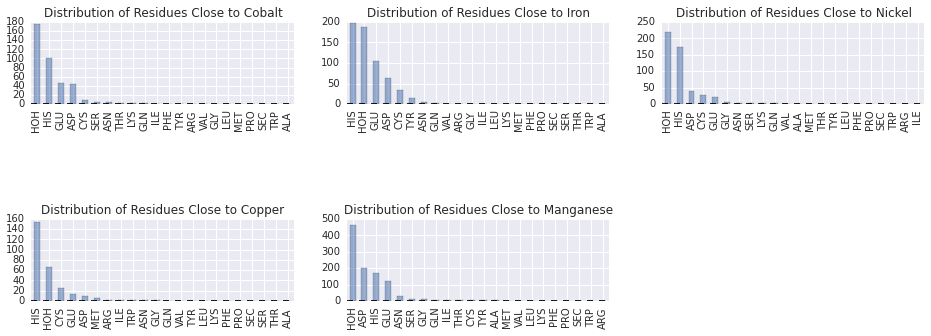

In [667]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(16,5), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

#plotting the distribution of amino acid contacts in each given metal
ax1 = plt.subplot2grid((3,3),(0,0))
cobalt.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Cobalt") 

plt.subplot2grid((3,3),(0,1))
iron.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Iron")

plt.subplot2grid((3,3),(0,2))
nickel.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Nickel")

plt.subplot2grid((3,3),(2,0))
copper.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Copper")

plt.subplot2grid((3,3),(2,1))
manganese.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Manganese")

The first issue that presents itself is the fact we have way too many dimensions present. There are a lot of ways I could flatten this dataset--I think it will make the most sense to reduce based on amino acid biochemistry. Since water, HIS, GLU, ASP, and CYS seem to all give high signal, I'm going to keep these as their own category.

In [263]:
def reduce_aa_dimensions(metal_df):
    '''Function that functionalizes amino acids that don't show up frequently for better clustering.'''
    
    hydrophobic = ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TYR', 'TRP', 'GLY', 'PRO']
    polar = ['SER', 'THR', 'ASN', 'GLN']
    positive = ['LYS', 'ARG']
    strongest_signal = ['HOH', 'HIS', 'GLU', 'ASP', 'CYS']
    
    hydrophobic_contacts = metal_df[hydrophobic].sum(axis=1)
    polar_contacts = metal_df[polar].sum(axis=1)
    positive_contacts = metal_df[positive].sum(axis=1)
    strong_contacts = metal_df[strongest_signal]

    metal_reduced = pd.DataFrame({'Hydrophobic contacts': hydrophobic_contacts, 'Polar Contacts': polar_contacts,
                                  'Positive Contacts': positive_contacts})
    final_reduced = pd.concat([metal_reduced, strong_contacts], axis=1)
    
    return final_reduced

In [668]:
cobalt_r = reduce_aa_dimensions(cobalt)
iron_r = reduce_aa_dimensions(iron)
copper_r = reduce_aa_dimensions(copper)
manganese_r = reduce_aa_dimensions(manganese)
nickel_r = reduce_aa_dimensions(nickel)

Now to regraph based on this reduced dataset. 

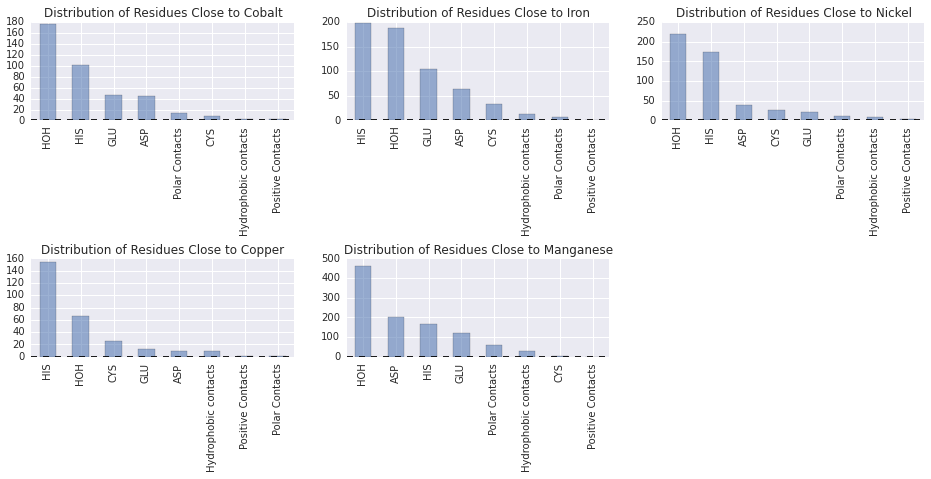

In [671]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(16,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

#plotting the distribution of amino acid contacts in each given metal
ax1 = plt.subplot2grid((3,3),(0,0))
cobalt_r.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Cobalt") 

plt.subplot2grid((3,3),(0,1))
iron_r.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Iron")

plt.subplot2grid((3,3),(0,2))
nickel_r.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Nickel")

plt.subplot2grid((3,3),(2,0))
copper_r.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Copper")

plt.subplot2grid((3,3),(2,1))
manganese_r.sum().order(ascending=False).plot(kind='bar', sort_columns=True, alpha=alpha_bar_chart)
plt.title("Distribution of Residues Close to Manganese")

So this it a bit easier to pick apart but let's make the patterns here a bit more apparent. I will also normalize these data for better comparison. 

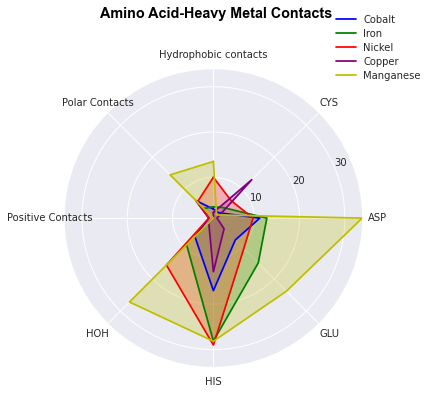

In [753]:
import numpy as np
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes."""
    # calculate evenly-spaced axis angles
    theta = 2 * np.pi * np.linspace(0, 1 - 1. / num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi / 2

    def draw_poly_frame(self, x0, y0, r):
        # TODO: use transforms to convert (x, y) to (r, theta)
        verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_frame(self, x0, y0, r):
        return plt.Circle((x0, y0), r)

    frame_dict = {'polygon': draw_poly_frame, 'circle': draw_circle_frame}
    if frame not in frame_dict:
        raise ValueError, 'unknown value for `frame`: %s' % frame

    class RadarAxes(PolarAxes):
        """Class for creating a radar chart (a.k.a. a spider or star chart)
        http://en.wikipedia.org/wiki/Radar_chart
        """
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_frame = frame_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180 / np.pi, labels)

        def _gen_axes_patch(self):
            x0, y0 = (0.5, 0.5)
            r = 0.5
            return self.draw_frame(x0, y0, r)

    register_projection(RadarAxes)
    return theta


if __name__ == '__main__':

    N = 8
    theta = radar_factory(N)
    spoke_labels = cobalt_r.columns.values.tolist()
    
    #this step noramlizes the signal from each metal
    cobalt_bar = cobalt_r.sum()/cobalt_r.max()
    cobalt_bar = np.asarray(cobalt_bar) 

    iron_bar = iron_r.sum()/iron_r.max()
    iron_bar = np.asarray(iron_bar) 
    
    nickel_bar = nickel_r.sum()/nickel_r.max()
    nickel_bar = np.asarray(nickel_bar)
    
    copper_bar = copper_r.sum()/copper_r.max()
    copper_bar = np.asarray(copper_bar)
    
    manganese_bar = manganese_r.sum()/manganese_r.max()
    manganese_bar = np.asarray(manganese_bar)

    fig = plt.figure(figsize=(12, 12))
    # adjust spacing around the subplots
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    title_list = ['']
    data = {'': [cobalt_bar, iron_bar, nickel_bar, copper_bar, manganese_bar]}
    colors = ['b', 'g', 'r', 'purple', 'y']
    # chemicals range from 0 to 1
    radial_grid = [10., 20., 30., 40.]
    # If you don't care about the order, you can loop over data_dict.items()
    for n, title in enumerate(title_list):
        ax = fig.add_subplot(2, 2, n + 1, projection='radar')
        plt.rgrids(radial_grid)
        ax.set_title(title, weight='bold', size='x-large', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(data[title], colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
    # add legend relative to top-left plot
    plt.subplot(2, 2, 1)
    labels = ('Cobalt', 'Iron', 'Nickel', 'Copper', 'Manganese')
    legend = plt.legend(labels, loc=(0.9, .95), labelspacing=0.4)
    plt.setp(legend.get_texts(), fontsize='medium')
    plt.figtext(0.30, 0.9, 'Amino Acid-Heavy Metal Contacts',
                ha='center', color='black', weight='bold', size='x-large')
    plt.show()

It looks like manganese resolves pretty well outside of the other heavy metals looked at here. Manganese appears to rely more equally on aspartic acid, water, glutamic acid, and histidine than other heavy metals. All metals appear to coordinate to histidine. This is likely why the porphyrin ring evolved as a cofactor. 

### Step 5: Resolving differences between binding patterns using ML

Now that we have the data, I'm curious if I can resolve the difference between some of these metals with a machine learning approach. For this I'm going to use the one vs rest (OvR) classifier. First off I'm going to change the index such that it matches the metal that the structure is coordinating, not the structure name itself. 

In [284]:
def change_index(df, name):
    new_index = []
    for i in range(len(df)):
        new_index.append(name)
    df.index = new_index
    return df

In [603]:
cobalt_new_index = change_index(cobalt_r, 'cobalt')
iron_new_index = change_index(iron_r, 'iron')
nickel_new_index = change_index(nickel_r, 'nickel')
copper_new_index = change_index(copper_r, 'copper')
manganese_new_index = change_index(manganese_r, 'manganese')

Now separate the classes and the feature data. 

In [604]:
IW_list = [cobalt_new_index, iron_new_index, nickel_new_index, copper_new_index, 
               manganese_new_index]

compiled_IW = pd.concat(IW_list)

Y = label_binarize(compiled_IW.index.values, classes=['cobalt', 'iron', 'nickel', 'copper', 'manganese'])
X = compiled_IW.as_matrix()

Split these up and test performance using a ROC curve. 

In [608]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [611]:
n_classes = 5

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

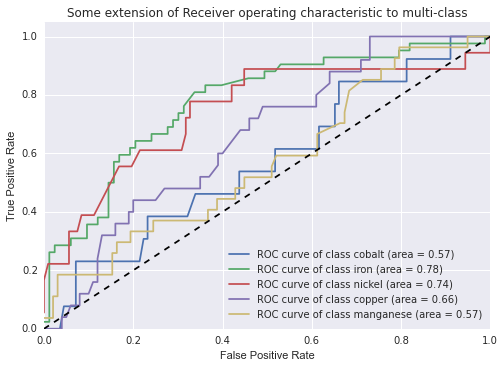

In [615]:
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
class_list = ['cobalt', 'iron', 'nickel', 'copper', 'manganese']

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         linewidth=2)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class ' + str(class_list[i]) + ' (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Parting thoughts

It looks like I was kind of able to separate some of the metal bindind motifs using the one vs rest approach. Because manganese appears to be bound by nearly every commonly accepted metal binding residue and water, it does not resolve very well in this classifier (really not much better than just random guessing). Iron and nickel's reliance on histidine are probably what separate it from the rest of metals in the Irving Williams series (the metals I chose here). Cobalt and nickel have fairly weak signals probably becasue they are less often used by biology as a cofactor and fewer unrelated structures would have their incorporation in common. Beyond looking at contacts, I think scripting up the ability to examine amino acid coordination would be insightful. 

Now for the biggest issue surrounding this kind of structural biology: this dataset is very biased even after my initial filtering. I have not sorted my data for natural or synthetic incorporation of these metals so I'm skeptical if these findings truly recapitulate a natural system. It can also be argued that heavy metal soaking of crystal structures changes the final resolved structure and that the contacts surrounding some of these metals are an artifact of the crystallization process.